In [16]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

from typing import Callable, List, Dict
from dataclasses import dataclass, field

In [2]:
X, y = load_iris(return_X_y=True)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, stratify=y)

In [23]:
class dataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()
        self.feature = features
        self.labels = labels
        self.f_transform = lambda x: torch.tensor(x, dtype=torch.float32)
        self.l_transform = lambda x: torch.tensor(x, dtype=torch.long)

    def  __getitem__(self, index):
        return self.f_transform(self.feature[index]), self.l_transform(self.labels[index])
    
    def __len__(self):
        return len(self.feature)
    
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network_layers = nn.Sequential(
            nn.Linear(in_features=4, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=3)
        )
    
    def forward(self, x):
        return self.network_layers(x)

@dataclass
class trainer():
    model: nn.Module
    train_loader: DataLoader
    val_loader: DataLoader
    loss_fn: Callable
    optimizer: torch.optim.Optimizer
    num_epochs: int
    train_loss: List[float] = field(default_factory=list)
    validation_loss: List[float] = field(default_factory=list)
    train_batch_losses: Dict[int, List] = field(default_factory=dict)
    validation_batch_losses: Dict[int, List] = field(default_factory=dict)
    training_done: bool = False
        

    def train(self):
        self.training_done = True

        for epoch in range(self.num_epochs):

            #setting model to train mode
            self.model.train()
            running_train_epoch_loss = 0.0
            running_train_batch_loss = 0.0
            batch_loss_train = []

            for inputs, output in self.train_loader:

                y_pred = self.model(inputs)
                loss = self.loss_fn(y_pred, output)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                batch_loss_train.append(loss.item())
                running_train_batch_loss += loss.item()

            self.train_batch_losses[epoch+1] = batch_loss_train
            running_train_epoch_loss += running_train_batch_loss
            average_train_epoch_loss = running_train_epoch_loss/len(self.train_loader)
            self.train_loss.append(average_train_epoch_loss)

            #setting the model to eval to study val loss
            self.model.eval()
            running_validation_epoch_loss = 0.0
            running_validation_batch_loss = 0.0
            batch_loss_val = []

            with torch.no_grad():
                for inputs, output in self.val_loader:

                    y_pred = self.model(inputs)
                    loss = self.loss_fn(y_pred, output)

                    running_validation_batch_loss += loss.item()
                    batch_loss_val.append(loss.item())
                
            running_validation_epoch_loss += running_validation_batch_loss
            average_validation_epoch_loss = running_validation_epoch_loss/len(self.val_loader)
            self.validation_loss.append(average_validation_epoch_loss)
            self.validation_batch_losses[epoch+1] = batch_loss_val

            print(f"Epoch[{epoch}/{self.num_epochs}],\t Train Loss: {average_train_epoch_loss:.4f},\t Validation Loss: {average_validation_epoch_loss:.4f}")
        
        return self.train_loss, self.validation_loss, self.train_batch_losses, self.validation_batch_losses
    
    def predict(self, test_loader: DataLoader) -> float:

        def prediction():
            #setting model to eval model for predictions
            self.model.eval()

            accuracy_score = 0.0
            total = 0

            with torch.no_grad():
                for inputs, output in test_loader:
                    y_pred = self.model(inputs)
                    _, predicted = torch.max(y_pred, dim=1)
                    total += output.size(0)
                    accuracy_score += (predicted == output).sum().item()

            return accuracy_score/total

        if self.training_done:
            return prediction()
        else:
            print("Predicting without training...")
            return prediction()



In [24]:
train_set = dataset(features=train_x, labels=train_y)
val_set = dataset(features=test_x, labels=test_y)

train_loader = DataLoader(train_set, batch_size=4)
val_loader = DataLoader(val_set, batch_size=4)

model = ANN()
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 20

trainer_obj = trainer(model, train_loader, val_loader, loss_fn, optimizer, num_epochs)
t_loss, v_loss, t_batch_loss, v_batch_loss = trainer_obj.train()
trainer_obj.predict(val_loader)

Epoch[0/20],	 Train Loss: 1.0407,	 Validation Loss: 0.8060
Epoch[1/20],	 Train Loss: 0.7113,	 Validation Loss: 0.5271
Epoch[2/20],	 Train Loss: 0.5390,	 Validation Loss: 0.4255
Epoch[3/20],	 Train Loss: 0.4569,	 Validation Loss: 0.3804
Epoch[4/20],	 Train Loss: 0.4016,	 Validation Loss: 0.3580
Epoch[5/20],	 Train Loss: 0.3565,	 Validation Loss: 0.3388
Epoch[6/20],	 Train Loss: 0.3117,	 Validation Loss: 0.3092
Epoch[7/20],	 Train Loss: 0.2678,	 Validation Loss: 0.2652
Epoch[8/20],	 Train Loss: 0.2279,	 Validation Loss: 0.2202
Epoch[9/20],	 Train Loss: 0.1973,	 Validation Loss: 0.1870
Epoch[10/20],	 Train Loss: 0.1753,	 Validation Loss: 0.1632
Epoch[11/20],	 Train Loss: 0.1583,	 Validation Loss: 0.1450
Epoch[12/20],	 Train Loss: 0.1449,	 Validation Loss: 0.1307
Epoch[13/20],	 Train Loss: 0.1344,	 Validation Loss: 0.1192
Epoch[14/20],	 Train Loss: 0.1258,	 Validation Loss: 0.1098
Epoch[15/20],	 Train Loss: 0.1189,	 Validation Loss: 0.1020
Epoch[16/20],	 Train Loss: 0.1131,	 Validation Los

1.0

In [34]:
import pandas as pd

losses = pd.DataFrame({"Train Loss": t_loss, 
                       "Validation Loss": v_loss})

losses

,Train Loss,Validation Loss
0,1.040732,0.805981
1,0.711294,0.527099
2,0.538988,0.425504
3,0.456864,0.380395
4,0.401647,0.357964
5,0.356502,0.338844
6,0.311725,0.309158
7,0.267764,0.265173
8,0.227908,0.220184
9,0.197342,0.187032


In [35]:
train_batch_loss = pd.DataFrame.from_dict(t_batch_loss, orient='index').transpose()
train_batch_loss.columns = [f"Epoch {epoch}" for epoch in train_batch_loss.columns]
train_batch_loss

,Epoch 1,Epoch 2,Epoch 3,Epoch 4,Epoch 5,Epoch 6,Epoch 7,Epoch 8,Epoch 9,Epoch 10,Epoch 11,Epoch 12,Epoch 13,Epoch 14,Epoch 15,Epoch 16,Epoch 17,Epoch 18,Epoch 19,Epoch 20
0,1.600504,1.049435,0.868225,0.723788,0.531646,0.375865,0.285421,0.232626,0.211162,0.208154,0.201447,0.186032,0.168426,0.150296,0.133229,0.118056,0.104748,0.093534,0.083679,0.075117
1,1.136507,0.866285,0.518446,0.369123,0.261914,0.184973,0.141273,0.115270,0.103748,0.099049,0.091752,0.081589,0.071613,0.062107,0.053778,0.046619,0.040552,0.035581,0.031314,0.027668
2,1.162208,0.706868,0.334073,0.239358,0.233232,0.240800,0.226943,0.193295,0.145428,0.102585,0.074908,0.057175,0.044660,0.036050,0.029738,0.025052,0.021464,0.018622,0.016407,0.014619
3,1.038912,0.801256,0.582920,0.517597,0.494660,0.479434,0.467512,0.449371,0.434008,0.431641,0.437841,0.446704,0.458207,0.469725,0.481773,0.493348,0.504551,0.515162,0.524694,0.533535
4,1.154007,0.759087,0.481169,0.406145,0.395702,0.390183,0.364805,0.321284,0.269099,0.226392,0.196742,0.173680,0.154080,0.138187,0.124687,0.113374,0.103657,0.095412,0.088464,0.082303
5,1.450111,0.765181,0.573359,0.505664,0.486049,0.457617,0.369068,0.257974,0.159248,0.100065,0.068547,0.049094,0.035835,0.027120,0.020960,0.016621,0.013389,0.011044,0.009316,0.007910
6,1.021081,0.755526,0.553562,0.473468,0.428938,0.380857,0.330366,0.288340,0.266435,0.255448,0.243911,0.234463,0.229023,0.225083,0.223407,0.222527,0.223278,0.223460,0.222824,0.223768
7,1.470442,0.884418,0.792279,0.706991,0.620959,0.518977,0.369229,0.233979,0.140865,0.092907,0.067004,0.049721,0.037390,0.028863,0.022624,0.018110,0.014634,0.012147,0.010309,0.008740
8,0.897869,0.633011,0.342131,0.239512,0.189102,0.158876,0.148771,0.144912,0.136209,0.113686,0.087575,0.066925,0.051909,0.040779,0.032705,0.026631,0.022204,0.018582,0.015688,0.013544
9,1.100022,0.950340,0.814970,0.711287,0.625194,0.523722,0.420400,0.335902,0.274706,0.237772,0.217017,0.204065,0.195853,0.191190,0.188058,0.186419,0.184022,0.184177,0.185804,0.185011


In [39]:
val_batch_loss = pd.DataFrame.from_dict(v_batch_loss, orient='index').transpose()
val_batch_loss.columns = [f"Epoch {epoch}" for epoch in val_batch_loss.columns]
val_batch_loss

,Epoch 1,Epoch 2,Epoch 3,Epoch 4,Epoch 5,Epoch 6,Epoch 7,Epoch 8,Epoch 9,Epoch 10,Epoch 11,Epoch 12,Epoch 13,Epoch 14,Epoch 15,Epoch 16,Epoch 17,Epoch 18,Epoch 19,Epoch 20
0,0.854645,0.613556,0.502502,0.414695,0.351425,0.305455,0.262948,0.224460,0.199718,0.185742,0.174727,0.165604,0.157212,0.149505,0.142581,0.136288,0.131031,0.126077,0.121458,0.117836
1,0.779846,0.553053,0.482574,0.479786,0.495076,0.500710,0.477924,0.417199,0.341128,0.282171,0.241643,0.211740,0.189806,0.173263,0.160387,0.150275,0.141822,0.135155,0.129764,0.124710
2,0.760056,0.528988,0.458534,0.455696,0.464911,0.459073,0.421376,0.348652,0.267118,0.207050,0.166613,0.137348,0.115930,0.099704,0.087024,0.076958,0.068685,0.061983,0.056427,0.051554
3,0.861405,0.619503,0.498869,0.404771,0.335324,0.284193,0.237614,0.195900,0.167170,0.147978,0.131636,0.117556,0.104940,0.093783,0.084100,0.075687,0.068698,0.062530,0.057100,0.052701
4,0.832977,0.694474,0.622682,0.577687,0.551561,0.526771,0.481550,0.410991,0.337040,0.281783,0.241940,0.211361,0.187438,0.168248,0.152569,0.139611,0.128772,0.119653,0.111872,0.105098
5,0.923199,0.595973,0.435676,0.309631,0.223309,0.172503,0.144586,0.135789,0.138427,0.138453,0.132340,0.124115,0.114739,0.105384,0.096684,0.088738,0.081910,0.075668,0.070029,0.065367
6,0.677608,0.376049,0.311260,0.348015,0.403011,0.432231,0.423596,0.369078,0.294773,0.239566,0.205438,0.182323,0.166917,0.156294,0.148608,0.143023,0.138337,0.134998,0.132555,0.129867
7,0.758115,0.235191,0.091936,0.052874,0.039098,0.029816,0.023673,0.019317,0.016094,0.013508,0.011457,0.009821,0.008492,0.007418,0.006540,0.005804,0.005179,0.004654,0.004204,0.003813


In [36]:
import matplotlib.pyplot as plt

def show_plots(df):
    num_epochs = len(df.columns)
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))  # 4x5 grid for 20 epochs
    fig.suptitle("Batch Losses for Each Epoch", fontsize=16)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for idx, column in enumerate(df.columns):
        ax = axes[idx]
        ax.plot(df.index, df[column], marker='o', linestyle='-')
        ax.set_title(column)
        ax.set_xlabel("Batch Number")
        ax.set_ylabel("Loss")
        ax.grid(True)

    # Remove empty subplots if any
    for idx in range(num_epochs, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
    plt.show()

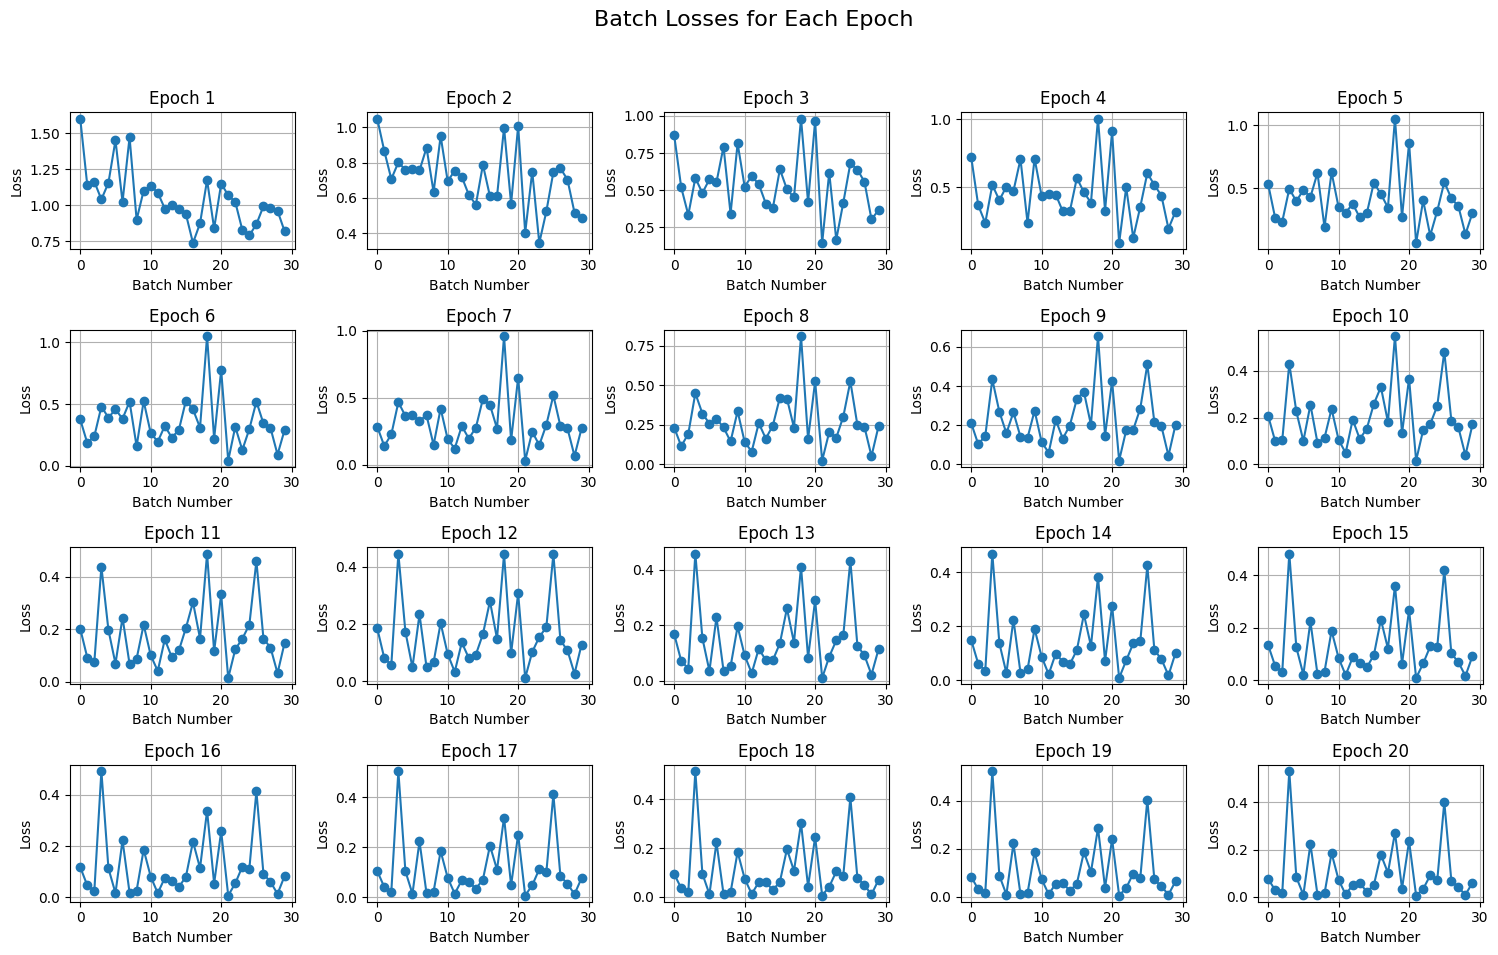

In [37]:
show_plots(train_batch_loss)

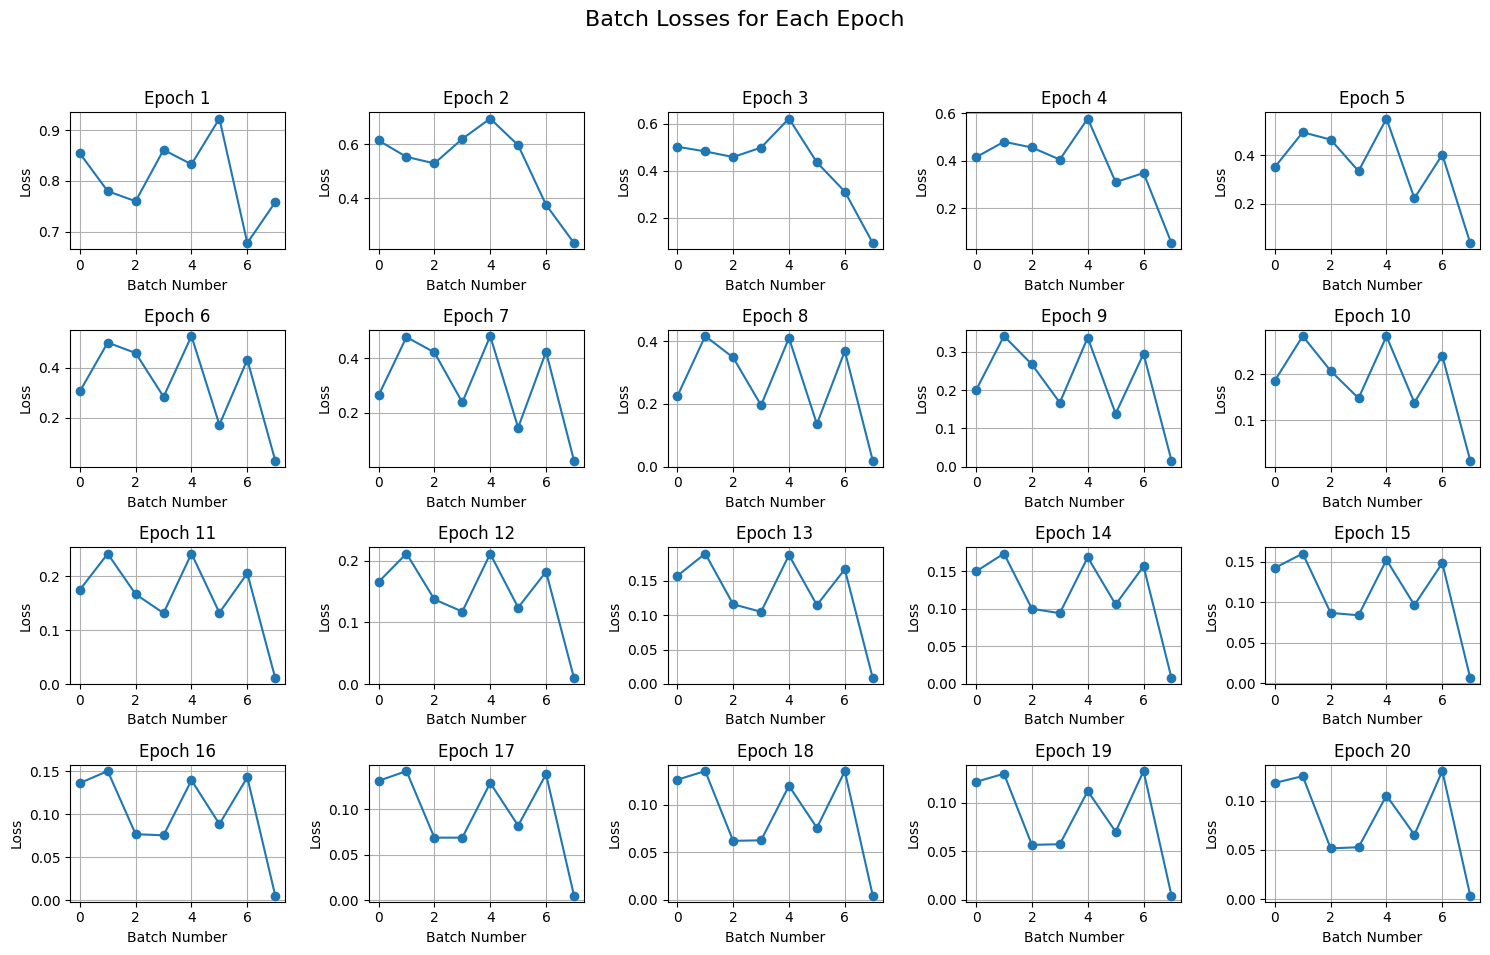

In [40]:
show_plots(val_batch_loss)